In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from cytograph.pipeline import load_config, PunchcardDeck
from cytograph.plotting import colorize
from cytograph.embedding import art_of_tsne
from cytograph.visualization import scatterm
from cytograph.species import Species
from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [2]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/figure2'

In [3]:
# get ncRNA gene names
with loompy.connect(f'{folder}/Pool.loom', 'r') as ds:
    accession_dict = dict(zip(
        pd.Series(ds.ra.Accession).str.split('.').str[0],
        np.arange(ds.shape[0])
    ))
    ncRNA_genes = np.loadtxt('ncRNA.txt', dtype='object')
    accession_ix = np.array([accession_dict.get(x, '') for x in ncRNA_genes])
    accession_ix = accession_ix[accession_ix != ''].astype('int')
    ncRNA_genes = ds.ra.Gene[accession_ix]

In [4]:
def skeletonize(nn, groups, labels, min_pct=1):
    
    row = []
    col = []
    weight = []
    
    for i, c1 in enumerate(groups):
        n_c1 = (labels == c1).sum()
        rc1 = labels[nn.row] == c1
        cc1 = labels[nn.col] == c1
        c1_internal = (rc1 & cc1).sum()
        for j, c2 in enumerate(groups):
            n_c2 = (labels == c2).sum()
            rc2 = labels[nn.row] == c2
            cc2 = labels[nn.col] == c2
            c2_internal = (rc2 & cc2).sum()
            c1c2_between = ((rc1 & cc2) | (rc2 & cc1)).sum()
            f = n_c1 / (n_c1 + n_c2)
            expected_fraction = (2 * f - 2 * f**2)
            observed_fraction = c1c2_between / (c1_internal + c2_internal + c1c2_between)
            # if observed_fraction > expected_fraction * (self.min_pct / 100):
            if observed_fraction > (min_pct / 100):
                row.append(i)
                col.append(j)
                weight.append(observed_fraction / expected_fraction)
                
    # make matrix of edges            
    n_clusters = len(groups)
    overlap = sparse.coo_matrix((weight, (row, col)), shape=(n_clusters, n_clusters)).A
    
    # remove edges within a group
    np.fill_diagonal(overlap, 0)
    
    return overlap

In [5]:
def clean_roi(roi_attr):
    return pd.Series(roi_attr).replace({r'[^\x00-\x7F]+':''}, regex=True).to_numpy()

# Figure 2A

In [6]:
A_names = {
    'A': 'Splatter',
    'B': 'Deep layer IT',
    'C': 'Upper layer IT', 
    'D': 'Amygdala excitatory',
    'E': 'Miscellaneous',
    'F': 'MGE interneurons', 
    'G': 'CGE interneurons', 
    'H': 'Thalamic excitatory',
    'I': 'Deep layer CT/b', 
    'J': 'Medium spiny neuron (MSN)', 
    'K': 'Upper rhombic lip', #CBLN3 and VGLUT1, no VGLUT2
    'L': 'Cerebellar inhibitory', 
    'M': 'Hipp. CA1-CA3', 
    'N': 'LAMP5-LHX6 and Chandelier', 
    'O': 'Hippcampus DG', 
    'P': 'Hippocampus CA4', 
    'Q': 'Eccentric MSN',  ## ?? ##
    'R': 'Deep layer NP', 
    'S': 'Midbrain-derived inhibitory', # also finding in the hindbrain?
    'T': 'Mammillary body',
    'U': 'Lower rhombic lip'  # HOX genes and VGLUT1/2
}

In [7]:
with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom') as ds:
    tissue = pd.Series(ds.ca.Tissue).str.split('(').str[0].str.split('-').str[0].str.strip().str.lower().str.capitalize()
    print(tissue.unique())

['Myelencephalon' 'Pons' 'Cerebellum' 'Midbrain' 'Thalamus' 'Hypothalamus'
 'Spinal cord' 'Basal forebrain' 'Body of hippocampus' 'Basal nuclei'
 'Amygdaloid complex' 'Cerebral cortex' 'Head of hippocampus'
 'Tail of hippocampus' 'Epithalamus' 'Extended amygdala' 'Paleocortex'
 'Claustrum' 'Perirhinal cortex']


In [8]:
with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom') as ds:

    roi_grp_attr = tissue.to_numpy()
    roi_grp_attr[tissue == 'Epithalamus'] = 'Thalamus'
    roi_grp_attr[tissue.str.contains('hippocampus')] = 'Hippocampus'
    roi_grp_attr[tissue == 'Paleocortex'] = 'Cerebral cortex'
    roi_grp_attr[tissue == 'Perirhinal cortex'] = 'Cerebral cortex'
    
    roi_group_dict = dict(zip(ds.ca.Roi, roi_grp_attr))
    
np.unique(roi_grp_attr)

array(['Amygdaloid complex', 'Basal forebrain', 'Basal nuclei',
       'Cerebellum', 'Cerebral cortex', 'Claustrum', 'Extended amygdala',
       'Hippocampus', 'Hypothalamus', 'Midbrain', 'Myelencephalon',
       'Pons', 'Spinal cord', 'Thalamus'], dtype=object)

In [9]:
roi_grp_order = [
        'Cerebral cortex',
        'Hippocampus',
        'Claustrum',
        'Basal nuclei',
        'Basal forebrain',
        'Amygdaloid complex',
        'Extended amygdala',
        'Hypothalamus',
        'Thalamus', 
        'Midbrain',
        'Cerebellum',
        'Pons',
        'Myelencephalon',
        'Spinal cord'
    ]

np.all([x in roi_grp_order for x in np.unique(roi_grp_attr)])

True

In [10]:
with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom', 'r') as ds:
    
    df = pd.DataFrame.from_dict(roi_group_dict, orient='index', columns=['ROI Group'])
    df.reset_index(inplace=True)
    order = dict(zip(roi_grp_order, range(len(roi_grp_order))))
    df['Order'] = [order.get(x) for x in df['ROI Group']]
    df.sort_values(by=['Order', 'index'], inplace=True)
    
    df['ROI Group Coarse'] = df['ROI Group']
    df['ROI Group Coarse'][df['ROI Group'].isin(['Claustrum', 'Basal nuclei','Basal forebrain', 'Amygdaloid complex', 'Extended amygdala'])] = 'Cerebral nuclei'
                           
df.head()

/var/lib/condor/execute/dir_3376266/ipykernel_171492/3838205549.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ROI Group Coarse'][df['ROI Group'].isin(['Claustrum', 'Basal nuclei','Basal forebrain', 'Amygdaloid complex', 'Extended amygdala'])] = 'Cerebral nuclei'


,index,ROI Group,Order,ROI Group Coarse
78,Human A13,Cerebral cortex,0,Cerebral cortex
81,Human A14,Cerebral cortex,0,Cerebral cortex
45,Human A19,Cerebral cortex,0,Cerebral cortex
68,Human A1C,Cerebral cortex,0,Cerebral cortex
61,Human A23,Cerebral cortex,0,Cerebral cortex


In [11]:
df.shape

(106, 4)

In [12]:
df.to_csv('roi_group_table.csv')

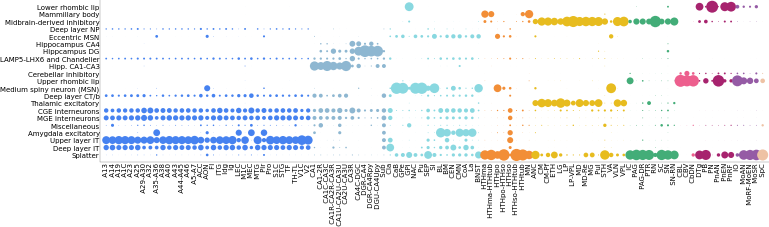

In [17]:
plt.figure(None, (12, 3))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom', 'r') as ds:
        
    # get ROIs and order by ROI Groups
    rois = df['index'].to_numpy()
    total_counts = np.array([(ds.ca.Roi == r).sum() for r in rois])
    rois = rois[total_counts > 50]
    total_counts = total_counts[total_counts > 50]
    superclusters, labels = np.unique(
        pd.Series(ds.ca.Punchcard).str.replace('harmony_A_', '').str.replace('_Clean', '').to_numpy(), 
        return_inverse=True
    )
    
    roi_counts = []
    x = []
    y = []
    colors = []
    for i, r in enumerate(rois):
        agg = npg.aggregate(labels, ds.ca.Roi == r) / total_counts[i]
        roi_counts.append(agg)
        x.append( [i] * len(superclusters) )
        y.append( range(len(superclusters)) )
        c = color_dict[df.query('index == @r')['ROI Group Coarse'].values[0]]
        colors = colors + [c] * len(superclusters)

    roi_counts = np.hstack(roi_counts)
    x = np.hstack(x)
    y = np.hstack(y)

    plt.scatter(x, y, s=roi_counts * 150, c=colors, rasterized=True, lw=0)
    ax.tick_params(length=0)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.xticks(range(len(rois)), pd.Series(rois).str.replace('Human', ''), rotation=90, fontsize=7)
    plt.yticks(range(len(superclusters)), [A_names[x] for x in superclusters], fontsize=7)
    plt.margins(0.01, 0.05)
    
    plt.show()

In [18]:
with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom', 'r') as ds:
        
    # get ROIs and order by ROI Groups
    rois = df['index'].to_numpy()
    total_counts = np.array([(ds.ca.Roi == r).sum() for r in rois])
    rois = rois[total_counts > 50]
    total_counts = total_counts[total_counts > 50]
    superclusters, labels = np.unique(
        pd.Series(ds.ca.Punchcard).str.replace('harmony_A_', '').str.replace('_Clean', '').to_numpy(), 
        return_inverse=True
    )
    
    roi_counts = []
    for i, r in enumerate(rois):
        agg = npg.aggregate(labels, ds.ca.Roi == r) / total_counts[i]
        roi_counts.append(agg)

    roi_counts = np.vstack(roi_counts)

In [19]:
X = roi_counts.reshape(len(rois), len(superclusters))
D = pdist(X.T, 'correlation')
Z = hc.linkage(D, 'complete')
cluster_order = hc.leaves_list(Z)

In [20]:
roi_counts = roi_counts[:, cluster_order].flatten()

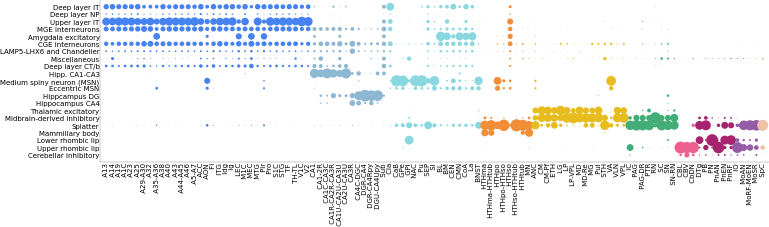

In [21]:
plt.figure(None, (12, 3))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/new_embeddings/data/harmony_A.loom', 'r') as ds:
        
    plt.scatter(x, y, s=roi_counts * 150, c=colors, rasterized=True, lw=0)
    ax.tick_params(length=0)
    plt.xticks(range(len(rois)), pd.Series(rois).str.replace('Human', ''), rotation=90, fontsize=7)
    plt.yticks(
        range(len(superclusters)),
        np.array([A_names[x] for x in superclusters[cluster_order]]),
        fontsize=7
    )
    plt.margins(0.01, 0.05)
    
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.gca().invert_yaxis()
    
    # plt.savefig(f'{figure_folder}/harmony_A_regions.pdf', dpi=300)

# Figure 2D

In [20]:
supercluster_path = '/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_A_B.loom'

In [21]:
with loompy.connect(folder + 'Pool.loom', 'r') as ds:
    cell_dict = dict(zip(ds.ca.CellID, ds.ca.ROIGroupCoarse))

with loompy.connect(supercluster_path, 'r') as ds:
    
    roi_attr = clean_roi(ds.ca.Roi)
    roi_group = np.array([cell_dict.get(x) for x in ds.ca.CellID])
    rois, node_size = np.unique(roi_attr[roi_group == 'Cerebral cortex'], return_counts=True)
    
    # skeletonize
    overlap = skeletonize(ds.col_graphs.KNN, rois, roi_attr, min_pct=0)

In [22]:
# make graph
G = nx.from_numpy_array(overlap)

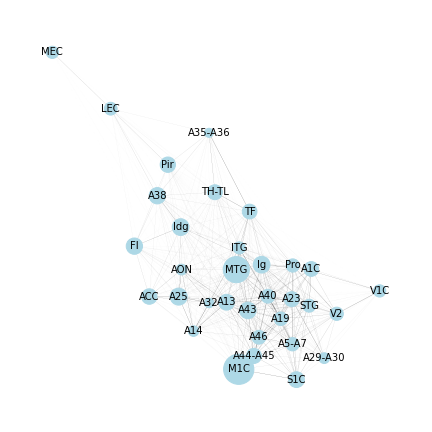

In [23]:
# rename nodes
nx.relabel_nodes(
    G, 
    dict(zip(range(len(rois)), pd.Series(rois).str.replace('Human ', ''))),
    copy=False)

# get edge weights and scale
edge_weight = np.divide(
    list(nx.get_edge_attributes(G, 'weight').values()), 
    5
)

node_color = 'lightblue'

plt.figure(None, (6, 6))
nx.draw(G, node_size=node_size / 25, with_labels=True, font_size=10, width=edge_weight, node_color=node_color)
plt.margins(0.1, 0.1)
plt.tight_layout()
# plt.savefig(f'{figure_folder}/cortex_graph_roi.pdf', dpi=300)

# Supp. Fig. 2A

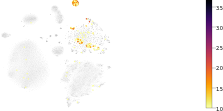

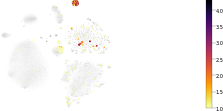

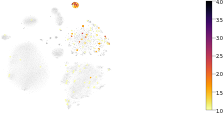

In [32]:
for g in ['SOX14', 'OTX2', 'CASR']:

    with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PnEN-RNA.loom', 'r') as ds:

        plt.figure(None, (4, 2))

        ax = plt.subplot(121)

        exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
        cells = exp > 0

        plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.01, s=2, lw=0, rasterized=True)
        plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=2, lw=0, rasterized=True, cmap='inferno_r')

        plt.axis('off')
        plt.margins(0.01, 0.01)

        ax = plt.subplot(122)
        plt.axis('off')
        cbar = plt.colorbar(ax=ax)
        cbar.ax.tick_params(labelsize=5)

        plt.subplots_adjust(wspace=0, hspace=0)

        plt.savefig(f'{figure_folder}/PnEN_{g}.pdf', dpi=300)

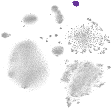

In [33]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/PnEN-RNA.loom', 'r') as ds:
    
    cells = (ds[np.where(ds.ra.Gene == 'CASR'), :].flatten() > 0) & (ds[np.where(ds.ra.Gene == 'OTX2'), :].flatten() > 0)
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/PnEN_OTXandCASR.pdf', dpi=300)   

# Supp. Fig. 3B-D

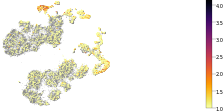

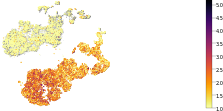

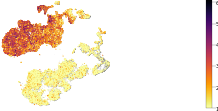

In [116]:
for g in ['CASZ1', 'DRD1', 'DRD2']:

    with loompy.connect(f'{folder}/harmony_A_J_Clean.loom', 'r') as ds:

            plt.figure(None, (4, 2))

            ax = plt.subplot(121)
            exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
            cells = exp > 0

            plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
            plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')

            plt.axis('off')
            plt.margins(0.02, 0.02)

            ax = plt.subplot(122)
            plt.axis('off')
            cbar = plt.colorbar(ax=ax)
            cbar.ax.tick_params(labelsize=5)

            plt.subplots_adjust(wspace=0, hspace=0)
            
            plt.savefig(f'{figure_folder}/eMSNs_{g}.pdf', dpi=300)

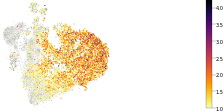

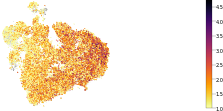

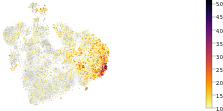

In [124]:
for g in ['CASZ1', 'DRD1', 'DRD2']:

    with loompy.connect(f'{folder}/harmony_A_Q_Clean.loom', 'r') as ds:

            plt.figure(None, (4, 2))

            ax = plt.subplot(121)
            exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
            cells = exp > 0

            plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
            plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')

            plt.axis('off')
            plt.margins(0.02, 0.02)

            ax = plt.subplot(122)
            plt.axis('off')
            cbar = plt.colorbar(ax=ax)
            cbar.ax.tick_params(labelsize=5)

            plt.subplots_adjust(wspace=0, hspace=0)
            
            plt.savefig(f'{figure_folder}/eMSNs_{g}.pdf', dpi=300)

['Human CaB' 'Human GPe' 'Human GPi' 'Human Pu']


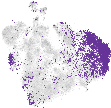

In [126]:
plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(f'{folder}/harmony_A_Q_Clean.loom', 'r') as ds:

    roi_attr = clean_roi(ds.ca.Roi)
    
    cells = pd.Series(roi_attr).isin(['Human CaB', 'Human Pu', 'Human NAc', 'Human GPe', 'Human GPi'])
    print(np.unique(roi_attr[cells]))
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/eMSNs_basalganglia.pdf', dpi=300)

In [9]:
eMSN = pd.read_csv('/proj/human_adult/20220222/harmony/analysis/eSPN-markers.csv')['gene'].str.upper().to_numpy()
eMSN[:100]

array(['ELAVL4', 'OTOF', 'CASZ1', 'ATP2B4', 'CACNG5', 'SPON1', 'GABRA3',
       '4930452B06RIK', 'CHN2', 'TMTC4', 'TSHZ1', 'CAR10', 'NRIP3',
       'PCDH8', 'SEMA5B', 'OLFM3', 'RALYL', 'NOG', 'NECAB1', 'CAMK2D',
       'ADARB2', 'ASIC2', 'RBP1', 'EFR3A', 'ERBB4', 'GNG2', 'MDFIC',
       'PLCB4', 'SEZ6L', 'FGFR1', 'ILDR2', 'KCNJ3', 'FAM19A2', 'KHDRBS3',
       'PTPRG', 'TRPM3', 'NFIX', 'PPM1E', 'TAC2', 'TACR1', 'TAC1',
       'FOXP2', 'NTNG1', 'LYPD1', 'PLXDC1', 'GNAS', 'RAB3B', 'SLC35F1',
       'AGTR1A', 'NXPH4', 'SCN5A', 'TH', 'CRTAC1', 'PCBP4', 'PTPRO',
       'FAM155A', 'SEMA3E', 'RXRG', 'SORCS1', 'NNAT', 'BASP1', 'ZFP804A',
       'SORL1', 'ACSL3', 'PBX1', '6330403K07RIK', 'PMEPA1', 'GAD2',
       'HS6ST2', 'CELF4', 'LSAMP', 'PCDH7', 'DLGAP1', 'PAK3', 'GPR83',
       'PTPRS', 'SYP', 'ARPP21', 'CAMK2N1', 'PPP1CA', 'ARPP19', 'GRM5',
       'DGKB', 'TOMM70A', 'TSPAN7', 'SPOCK3', 'SCN4B', 'TMEM158', 'RGS4',
       'PRKCB', 'AKAP5', 'SLC24A2', 'PENK', 'KLHL13', 'PPP1R7',
       'SERPIN

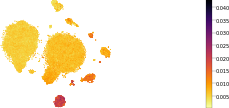

In [30]:
plt.figure(None, (4, 2))

with loompy.connect(f'/proj/human_adult/20220222/harmony/analysis/data/CaB.loom', 'r') as ds:

    ax = plt.subplot(121)
    
    n_genes = 50
    ix = pd.Series(ds.ra.Gene).isin(eMSN[:n_genes]).to_numpy()
    score = np.sum(ds[ix, :], axis=0)
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], c=score / ds.ca.TotalUMI, s=1, lw=0, rasterized=True, cmap='inferno_r')
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    ax = plt.subplot(122)
    plt.axis('off')
    cbar = plt.colorbar(ax=ax)
    cbar.ax.tick_params(labelsize=5)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.savefig(f'{figure_folder}/eMSNs_CaB_score.pdf', dpi=300)

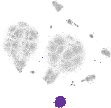

In [31]:
with loompy.connect(f'{folder}/harmony_A_Q_Clean.loom', 'r') as ds:
    cell_ids = ds.ca.CellID

plt.figure(None, (2, 2))
ax = plt.subplot(111)

with loompy.connect(f'/proj/human_adult/20220222/harmony/analysis/data/CaB.loom', 'r') as ds:
    
    cells = pd.Series(ds.ca.CellID).isin(cell_ids)
    plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
    plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c='rebeccapurple', s=1, lw=0, rasterized=True)
    
    plt.margins(0.01, 0.01)
    plt.axis('off')
    
    plt.savefig(f'{figure_folder}/eMSNs_CaB.pdf', dpi=300)   

In [ ]:
with loompy.connect(folder + 'harmony_A_F.loom', 'r') as ds:
    counts = []
    for reg in region_list:
        c = (ds.ca.Roi == reg) & (ds[ds.ra.Gene == 'FOXG1', :] > 0)
        c = c.sum() / (ds.ca.Roi == reg).sum()
        counts.append(c)
            
n_regions = len(region_list)
bottom = np.zeros(n_regions)
plt.figure(None, (20, 3))
plt.bar(range(n_regions), counts)
plt.xticks(range(n_regions), region_list, rotation=90)
plt.show()

In [ ]:
with loompy.connect(folder + 'harmony_A_F.loom', 'r') as ds:
    frac = []
    colors = []
    for reg in region_list:
        if (ds.ca.Roi == reg).sum() > 5:
            f = (ds.ca.Roi == reg) & (ds[ds.ra.Gene == 'FOXG1', :] > 0)
            f = f.sum() / (ds.ca.Roi == reg).sum()
            frac.append(f)
        else:
            frac.append(0)
        colors.append(
            color_dict[df.query('index == @reg')['ROI Group Coarse'].values[0]]
        )
        
plt.figure(None, (2.5, 1))
plt.bar(
    region_list,
    frac,
    width=1, 
    color=colors
)
plt.xticks([])
plt.margins(x=0.01)
plt.show()

In [ ]:
with loompy.connect(folder + 'harmony_A_F.loom', 'r') as ds:
    counts = []
    for reg in region_list:
        c = (ds.ca.Roi == reg) & (ds[ds.ra.Gene == 'LHX6', :] > 0)
        c = c.sum() / (ds.ca.Roi == reg).sum()
        counts.append(c)
            
n_regions = len(region_list)
bottom = np.zeros(n_regions)
plt.figure(None, (20, 3))
plt.bar(range(n_regions), counts)
plt.xticks(range(n_regions), region_list, rotation=90)
plt.show()

In [ ]:
with loompy.connect(folder + 'harmony_A_F.loom', 'r') as ds:
    frac = []
    colors = []
    for reg in region_list:
        if (ds.ca.Roi == reg).sum() > 5:
            f = (ds.ca.Roi == reg) & (ds[ds.ra.Gene == 'LHX6', :] > 0)
            f = f.sum() / (ds.ca.Roi == reg).sum()
            frac.append(f)
        else:
            frac.append(0)
        colors.append(
            color_dict[df.query('index == @reg')['ROI Group Coarse'].values[0]]
        )
        
plt.figure(None, (2.5, 1))
plt.bar(
    region_list,
    frac,
    width=1, 
    color=colors
)
plt.xticks([])
plt.margins(x=0.01)
plt.show()

In [ ]:
with loompy.connect(folder + 'harmony_A_G.loom', 'r') as ds:
    counts = []
    for reg in region_list:
        c = (ds.ca.Roi == reg) & (ds[ds.ra.Gene == 'FOXG1', :] > 0)
        c = c.sum() / (ds.ca.Roi == reg).sum()
        counts.append(c)
            
n_regions = len(region_list)
bottom = np.zeros(n_regions)
plt.figure(None, (20, 3))
plt.bar(range(n_regions), counts)
plt.xticks(range(n_regions), region_list, rotation=90)
plt.show()

In [ ]:
with loompy.connect(folder + 'harmony_A_G.loom', 'r') as ds:
    frac = []
    colors = []
    for reg in region_list:
        if (ds.ca.Roi == reg).sum() > 5:
            f = (ds.ca.Roi == reg) & (ds[ds.ra.Gene == 'FOXG1', :] > 0)
            f = f.sum() / (ds.ca.Roi == reg).sum()
            frac.append(f)
        else:
            frac.append(0)
        colors.append(
            color_dict[df.query('index == @reg')['ROI Group Coarse'].values[0]]
        )
        
plt.figure(None, (2.5, 1))
plt.bar(
    region_list,
    frac,
    width=1, 
    color=colors
)
plt.xticks([])
plt.margins(x=0.01)
plt.show()

In [ ]:
with loompy.connect(folder + 'harmony_A_G.loom', 'r') as ds:
    counts = []
    for reg in region_list:
        c = (ds.ca.Roi == reg) & (ds[ds.ra.Gene == 'ADARB2', :] > 0)
        c = c.sum() / (ds.ca.Roi == reg).sum()
        counts.append(c)
            
n_regions = len(region_list)
bottom = np.zeros(n_regions)
plt.figure(None, (20, 3))
plt.bar(range(n_regions), counts)
plt.xticks(range(n_regions), region_list, rotation=90)
plt.show()

In [ ]:
with loompy.connect(folder + 'harmony_A_G.loom', 'r') as ds:
    frac = []
    colors = []
    for reg in region_list:
        if (ds.ca.Roi == reg).sum() > 5:
            f = (ds.ca.Roi == reg) & (ds[ds.ra.Gene == 'ADARB2', :] > 0)
            f = f.sum() / (ds.ca.Roi == reg).sum()
            frac.append(f)
        else:
            frac.append(0)
        colors.append(
            color_dict[df.query('index == @reg')['ROI Group Coarse'].values[0]]
        )
        
plt.figure(None, (2.5, 1))
plt.bar(
    region_list,
    frac,
    width=1, 
    color=colors
)
plt.xticks([])
plt.margins(x=0.01)
plt.show()

In [ ]:
with loompy.connect(f'/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_A_C_Clean.loom', 'r') as ds:
    print(np.unique(ds.ca.Roi).shape)